https://medium.com/mlearning-ai/ultimate-guide-to-graph-neural-networks-1-cora-dataset-37338c04fe6f

https://towardsdatascience.com/how-to-create-a-graph-neural-network-in-python-61fd9b83b54e


In [2]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


ModuleNotFoundError: No module named 'torch_scatter'

In [7]:
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm
#from torch_geometric.data.DataLoader import NeighborLoader
#from torch_geometric.loader import NeighborLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.nn import MessagePassing, SAGEConv
from ogb.nodeproppred import Evaluator, PygNodePropPredDataset

In [9]:
from torch_geometric.loader import NeighborLoader

ImportError: cannot import name 'HeteroData' from 'torch_geometric.data' (/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch_geometric/data/__init__.py)

https://pypi.org/project/torch-geometric/

https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html


In [29]:
import torch
from torch import Tensor
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid

import torch.nn.functional as F

#dataset = Planetoid(root='.', name='Cora')

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        # x: Node feature matrix of shape [num_nodes, in_channels]
        # edge_index: Graph connectivity matrix of shape [2, num_edges] ( similar to adj mat) elist?
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x
    
    # alternative forward function
    def forward2(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x,training= self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
    
    def forward3(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        # f maps vertices to their properties (?)
        
    def forward4(self, x, edge_index):
        # use a grakel score function here 

num_features=5
num_classes=5
model = GCN(num_features, 16, num_classes)

In [ ]:
model.fit()

GCN layer is $x_i^{(k)} = \sum_j \frac{1}{ \sqrt{deg(i)} \sqrt{deg(j)}} (W^T \cdot x_j^{(k-1)}) +b$

W: weight matrix, b: bias vector


propagate(), which internally calls message(), aggregate() and update()

The edge conv layer processes graphs/pt clouds and is $x_i^{(k)} = \max_j h_{\theta}(x_i^{(k-1)}, x_j^{(k-1)} - x_i^{(k-1)})$ 

where $h_{\theta}$ denotes an MLP

message gives the torch.cat([x_i, x_j - x_i], dim=1)  and returns mlp of it

In [44]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.Tensor(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm)

        # Step 6: Apply a final bias vector.
        out += self.bias

        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#data =  data.to(device)

model_gcn = GCNConv(3, 128).to(device) 

In [ ]:
model_gcn.train()

In [ ]:
# next: go on papers with code to see how gnn can help with graph classfn 


In [42]:
# exercise 
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous())

#1. row and col hold each row / col of edge_index
#2. degree is number of edges out of a vertex
#3. why we use deg(col,...) instead of deg(row,...) is because 
#4. deg_inv_sqrt[col] and deg_inv_sqrt[row] do 


In [43]:
row, col = edge_index

ValueError: too many values to unpack (expected 2)

In [ ]:
# how to adapt the architecture from node classfn to graph classfn?

In [30]:
import networkx as nx
from sklearn.preprocessing import StandardScaler

g_karate = nx.karate_club_graph()

In [32]:
labels = np.asarray([g_karate.nodes[i]['club'] != 'Mr. Hi' for i in g_karate.nodes]).astype(np.int64)


In [38]:
# create edge index from 
G = g_karate
adj = nx.to_scipy_sparse_matrix(G).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row, col], dim=0)

# using degree as embedding
embeddings = np.array(list(dict(G.degree()).values()))

# normalizing degree values
scale = StandardScaler()
embeddings = scale.fit_transform(embeddings.reshape(-1,1))

1. Generate numerical representations for each node in the graph (node degree in this case).
2. Construct a PyG custom dataset and split data into train and test.
3. Use a GNN model like GCN and train the model.
4. Make predictions on the test set and calculate the accuracy score.

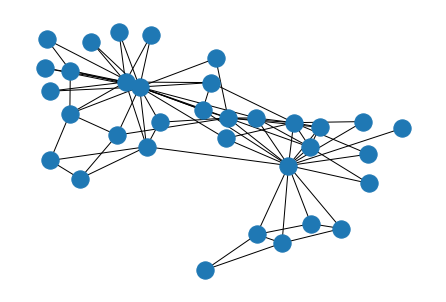

In [36]:
nx.draw(g_karate)

In [39]:
import torch
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data
from sklearn.model_selection import train_test_split
import torch_geometric.transforms as T

# custom dataset
class KarateDataset(InMemoryDataset):
    def __init__(self, transform=None):
        super(KarateDataset, self).__init__('.', transform, None, None)

        data = Data(edge_index=edge_index)
        
        data.num_nodes = G.number_of_nodes()
        
        # embedding 
        data.x = torch.from_numpy(embeddings).type(torch.float32)
        
        # labels
        y = torch.from_numpy(labels).type(torch.long)
        data.y = y.clone().detach()
        
        data.num_classes = 2

        # splitting the data into train, validation and test
        X_train, X_test, y_train, y_test = train_test_split(pd.Series(list(G.nodes())), 
                                                            pd.Series(labels),
                                                            test_size=0.30, 
                                                            random_state=42)
        
        n_nodes = G.number_of_nodes()
        
        # create train and test masks for data
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[X_train.index] = True
        test_mask[X_test.index] = True
        data['train_mask'] = train_mask
        data['test_mask'] = test_mask

        self.data, self.slices = self.collate([data])

    def _download(self):
        return

    def _process(self):
        return

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)
    
dataset = KarateDataset()
data = dataset[0]

In [40]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# GCN model with 2 layers 
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(data.num_features, 16)
        self.conv2 = GCNConv(16, int(data.num_classes))

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data =  data.to(device)

model = Net().to(device) 

In [41]:
# predict the missing labels

torch.manual_seed(42)

optimizer_name = "Adam"
lr = 1e-1
optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
epochs = 200

def train():
  model.train()
  optimizer.zero_grad()
  F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
  optimizer.step()

@torch.no_grad()
def test():
  model.eval()
  logits = model()
  mask1 = data['train_mask']
  pred1 = logits[mask1].max(1)[1]
  acc1 = pred1.eq(data.y[mask1]).sum().item() / mask1.sum().item()
  mask = data['test_mask']
  pred = logits[mask].max(1)[1]
  acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
  return acc1,acc

for epoch in range(1, epochs):
  train()

train_acc,test_acc = test()

print('#' * 70)
print('Train Accuracy: %s' %train_acc )
print('Test Accuracy: %s' % test_acc)

######################################################################
Train Accuracy: 0.9130434782608695
Test Accuracy: 0.7272727272727273


In [11]:
# create your own GNN layer:

import torch
from torch import Tensor
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing

class EdgeConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr="max")  # "Max" aggregation.
        self.mlp = Sequential(
            Linear(2 * in_channels, out_channels),
            ReLU(),
            Linear(out_channels, out_channels),
        )

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        # x: Node feature matrix of shape [num_nodes, in_channels]
        # edge_index: Graph connectivity matrix of shape [2, num_edges]
        
        # is this the function which is f(x) (?)
        
        return self.propagate(edge_index, x=x)  # shape [num_nodes, out_channels]

    def message(self, x_j: Tensor, x_i: Tensor) -> Tensor:
        # x_j: Source node features of shape [num_edges, in_channels]
        # x_i: Target node features of shape [num_edges, in_channels]
        edge_features = torch.cat([x_i, x_j - x_i], dim=-1)
        return self.mlp(edge_features)  # shape [num_edges, out_channels]

In [16]:
pre

NameError: name 'pre' is not defined

In [25]:
# reader in auxiliary methods

import os.path as path
import networkx as nx


def tud_to_networkx(ds_name):
    #pre = ds_name + "/"

    with open( ds_name + "/" + ds_name + "_graph_indicator.txt", "r") as f:
        graph_indicator = [int(i) - 1 for i in list(f)]
    f.closed

    # Nodes.
    num_graphs = max(graph_indicator)
    node_indices = []
    offset = []
    c = 0

    for i in range(num_graphs + 1):
        offset.append(c)
        c_i = graph_indicator.count(i)
        node_indices.append((c, c + c_i - 1))
        c += c_i

    graph_db = []
    for i in node_indices:
        g = nx.Graph()
        for j in range(i[1] - i[0]+1):
            g.add_node(j)

        graph_db.append(g)

    # Edges.
    with open(ds_name + "/" + ds_name + "_A.txt", "r") as f:
        edges = [i.split(',') for i in list(f)]
    f.closed
    
    edges = [(int(e[0].strip()) - 1, int(e[1].strip()) - 1) for e in edges]
    edge_list = []
    edgeb_list = []
    for e in edges:
        g_id = graph_indicator[e[0]]
        g = graph_db[g_id]
        off = offset[g_id]

        # Avoid multigraph (for edge_list)
        if ((e[0] - off, e[1] - off) not in list(g.edges())) and ((e[1] - off, e[0] - off) not in list(g.edges())):
            g.add_edge(e[0] - off, e[1] - off)
            edge_list.append((e[0] - off, e[1] - off))
            edgeb_list.append(True)
        else:
            edgeb_list.append(False)

    # Node labels.
    if path.exists(ds_name + "/" + ds_name + "_node_labels.txt"):
        with open(ds_name + "/" + ds_name + "_node_labels.txt", "r") as f:
            node_labels = [str.strip(i) for i in list(f)]
        f.closed
        
        node_labels = [i.split(',') for i in node_labels]
        int_labels = [];
        
        for i in range(len(node_labels)):
            int_labels.append([int(j) for j in node_labels[i]])
        # add to it ?
        
        i = 0
        for g in graph_db:
            n_labs = [] # added
            for v in range(g.number_of_nodes()):
                g.nodes[v]['labels'] = int_labels[i]
                n_labs.append(int_labels[i]) # added 
                
                i += 1
            g.n_labels = n_labs # added 
            

    # Node Attributes.
    if path.exists(ds_name + "/" + ds_name + "_node_attributes.txt"):
        with open(ds_name + "/" + ds_name + "_node_attributes.txt", "r") as f:
            node_attributes = [str.strip(i) for i in list(f)]
        f.closed
        
        node_attributes = [i.split(',') for i in node_attributes]
        float_attributes = [];
        for i in range(len(node_attributes)):
            float_attributes.append([float(j) for j in node_attributes[i]])
        i = 0
        for g in graph_db:
            for v in range(g.number_of_nodes()):
                g.nodes[v]['attributes'] = float_attributes[i]
                i += 1

    # Edge Labels.
    if path.exists(ds_name + "/" + ds_name + "_edge_labels.txt"):
        with open(ds_name + "/" + ds_name + "_edge_labels.txt", "r") as f:
            edge_labels = [str.strip(i) for i in list(f)]
        f.closed

        edge_labels = [i.split(',') for i in edge_labels]
        e_labels = [];
        for i in range(len(edge_labels)):
            if(edgeb_list[i]):
                e_labels.append([int(j) for j in edge_labels[i]])
        
        i = 0
        for g in graph_db:
            
            for e in range(g.number_of_edges()):
                g.edges[edge_list[i]]['labels'] = e_labels[i]
                i += 1

    # Edge Attributes.
    if path.exists(ds_name + "/" + ds_name + "_edge_attributes.txt"):
        with open( ds_name + "/" + ds_name + "_edge_attributes.txt", "r") as f:
            edge_attributes = [str.strip(i) for i in list(f)]
        f.closed

        edge_attributes = [i.split(',') for i in edge_attributes]
        e_attributes = [];
        for i in range(len(edge_attributes)):
            if(edgeb_list[i]):
                e_attributes.append([float(j) for j in edge_attributes[i]])
        
        i = 0
        for g in graph_db:
            for e in range(g.number_of_edges()):
                g.edges[edge_list[i]]['attributes'] = e_attributes[i]
                i += 1

    # Classes.
    if path.exists(ds_name + "/" + ds_name + "_graph_labels.txt"):
        with open(ds_name + "/" + ds_name + "_graph_labels.txt", "r") as f:
            classes = [str.strip(i) for i in list(f)]
        f.closed
        classes = [i.split(',') for i in classes]
        cs = [];
        for i in range(len(classes)):
            cs.append([int(j) for j in classes[i]])
        
        i = 0
        for g in graph_db:
            g.graph['classes'] = cs[i]
            i += 1

    # Targets.
    if path.exists(ds_name + "/" + ds_name + "_graph_attributes.txt"):
        with open(ds_name + "/" + ds_name + "_graph_attributes.txt", "r") as f:
            targets = [str.strip(i) for i in list(f)]
        f.closed
        
        targets= [i.split(',') for i in targets]
        ts = [];
        for i in range(len(targets)):
            ts.append([float(j) for j in targets[i]])
        
        i = 0
        for g in graph_db:
            g.graph['targets'] = ts[i]
            i += 1

    return graph_db # e_labels # used to just return graph_db

# g.edges
# g.n_labels 
# g.nodes[v]['labels']   node labels 
# g.edges[edge_list[i]]['labels'] ?  edge labels 
# e_labels
# g.edges[edge_list[i]]['attributes']
# g.graph['classes']
# g.graph['targets']


In [26]:
g_db2 = tud_to_networkx("ENZYMES")

https://distill.pub/2021/gnn-intro/

In [ ]:
# encode the kernel function(s) into the forward function 
